In [1]:
import os
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import imageio

/home/hlovatskyi/anaconda3/envs/segm/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from single_img_inf import SingleClassRefiner

In [6]:
img_path, mask_path = "human/9_im.jpg", "data/human/9_seg.png"
im, mask = Image.open(img_path).convert('RGB'), Image.open(mask_path).convert('L')

sr = SingleClassRefiner()
# im, ref = sr(im, mask)

ASPP_4level


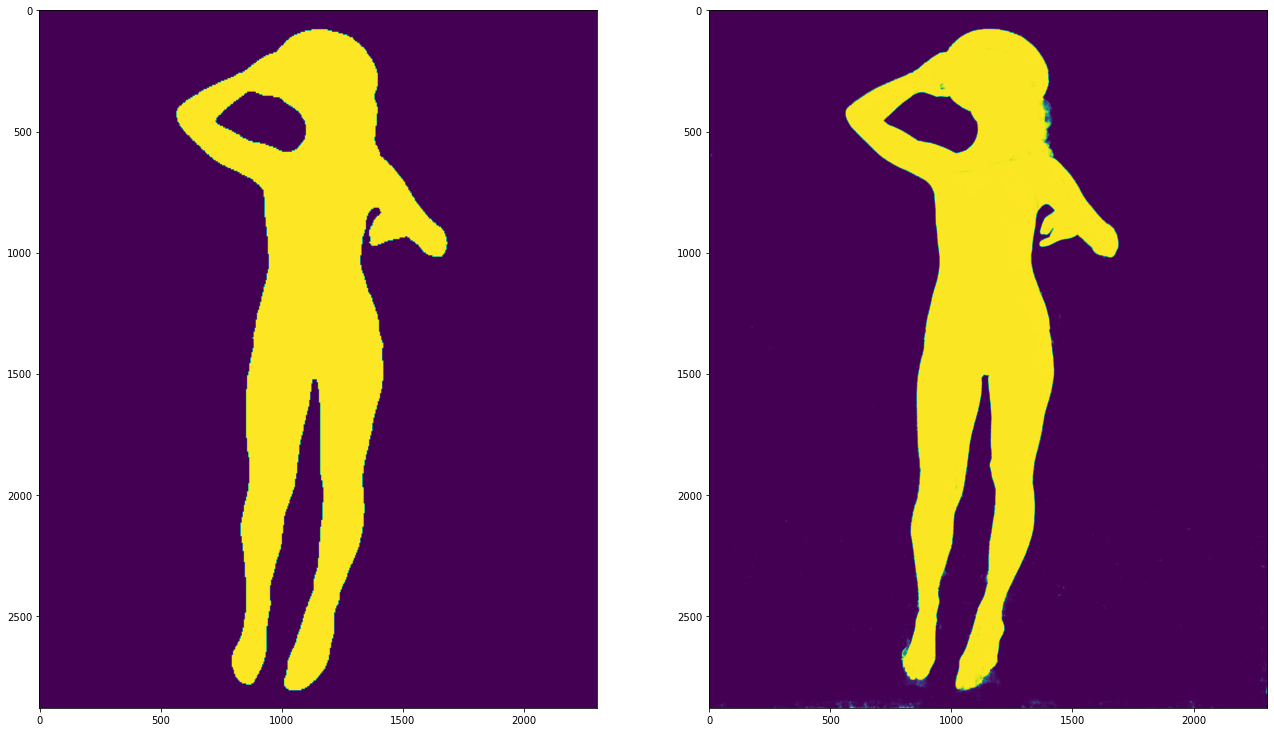

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22, 18))
ax[0].imshow(mask)
ax[1].imshow((ref[0].permute(1, 2, 0).numpy() * 255).astype(np.uint8))

## Now it is time for human parsing!!!

In [16]:
!pip install ninja
!git clone https://github.com/PeikeLi/Self-Correction-Human-Parsing
%cd Self-Correction-Human-Parsing
!mkdir checkpoints
!mkdir inputs
!mkdir outputs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 2.1 MB/s eta 0:00:001.7 MB/s eta 0:00:01
Cloning into 'Self-Correction-Human-Parsing'...
remote: Enumerating objects: 719, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 719 (delta 41), reused 32 (delta 32), pack-reused 650
Receiving objects: 100% (719/719), 3.79 MiB | 4.45 MiB/s, done.
Resolving deltas: 100% (153/153), done.
/home/hlovatskyi/Entity/High-Quality-Segmention/Self-Correction-Human-Parsing


NameError: name 'gdown' is not defined

In [19]:
import gdown

output = 'checkpoints/final.pth'
gdown.download(
    'https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH',
    output,
    quiet=False
)

Downloading...
From: https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH
To: /home/hlovatskyi/Entity/High-Quality-Segmention/Self-Correction-Human-Parsing/checkpoints/final.pth
100%|██████████| 267M/267M [00:23<00:00, 11.2MB/s] 


'checkpoints/final.pth'

In [21]:
%cd Self-Correction-Human-Parsing

/home/hlovatskyi/Entity/High-Quality-Segmention/Self-Correction-Human-Parsing


In [25]:
!python3 simple_extractor.py --dataset 'lip' --model-restore 'checkpoints/final.pth' --input-dir '../human' --output-dir 'outputs2'

Evaluating total class number 20 with ['Background', 'Hat', 'Hair', 'Glove', 'Sunglasses', 'Upper-clothes', 'Dress', 'Coat', 'Socks', 'Pants', 'Jumpsuits', 'Scarf', 'Skirt', 'Face', 'Left-arm', 'Right-arm', 'Left-leg', 'Right-leg', 'Left-shoe', 'Right-shoe']
  0%|                                                     | 0/1 [00:00<?, ?it/s][473, 473]
[1151.5 1439.5] [2879. 2879.] 2304 2880 [473, 473]
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


In [28]:
%cd ..

/home/hlovatskyi/Entity/High-Quality-Segmention


In [7]:
hp_path, gt_path = "Self-Correction-Human-Parsing/outputs/9_im.png", "human/9_im.jpg"

In [8]:
im, mask = np.array(Image.open(gt_path).convert('RGB')), np.array(Image.open(hp_path).convert('L'))

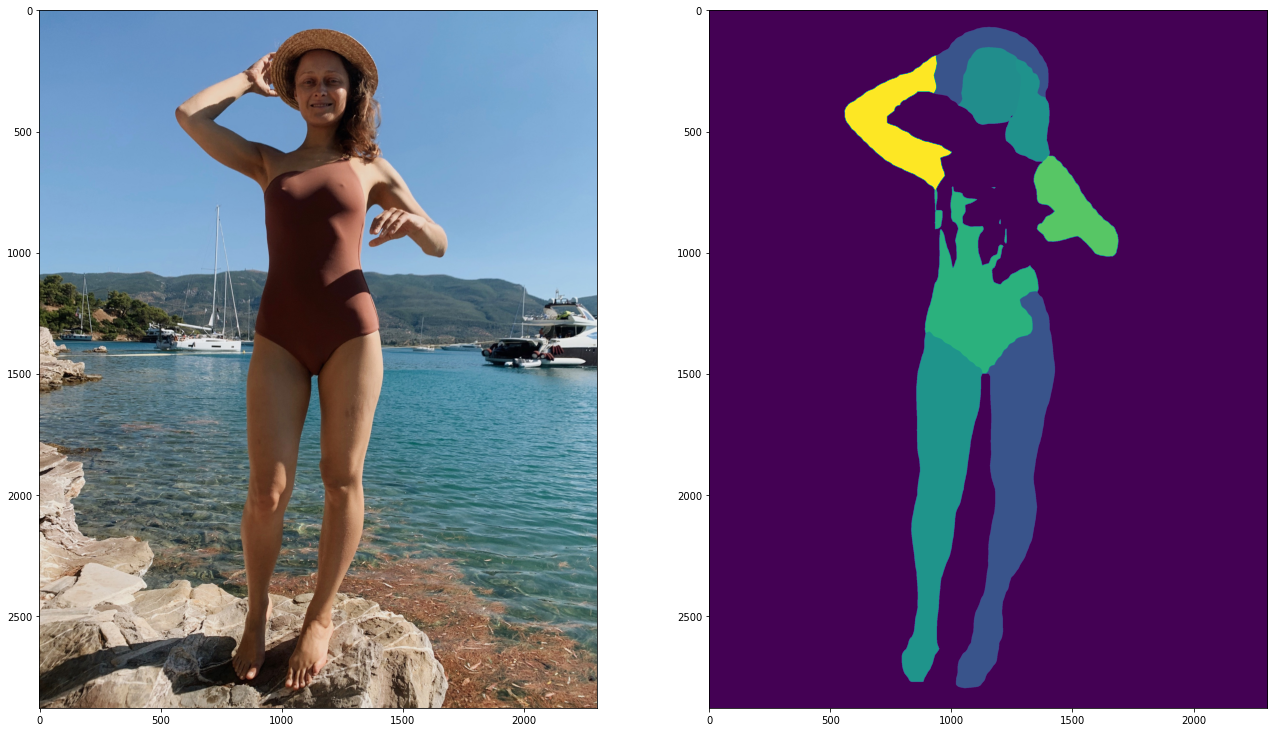

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22, 18))
ax[0].imshow(im)
ax[1].imshow(mask)

In [78]:
def extract_bboxes(mask, scale: float = 1.5):
    boxes = np.zeros([mask.shape[0], 4], dtype=np.int32)
    
    for i in range(mask.shape[0]):
        msk = mask[i, :, :]
        
        horizontal_indicies = np.where(np.any(msk, axis=0))[0]
        vertical_indicies = np.where(np.any(msk, axis=1))[0]
    
        h, w = msk.shape

        if horizontal_indicies.shape[0]:
            x1, x2 = horizontal_indicies[[0, -1]]
            y1, y2 = vertical_indicies[[0, -1]]
            x2 += 1
            y2 += 1
            
            bbwd = x2 - x1
            bbht = y2 - y1
            
            inv_width_scale = bbwd * scale**-1
            inv_height_scale = bbwd * scale**-1
            
            x1 = max(0, x1 - inv_width_scale)
            y1 = max(0, y1 - inv_height_scale)
            x2 = min(w, x2 + inv_width_scale)
            y2 = min(h, y2 + inv_height_scale)
            
        else:
            x1, x2, y1, y2 = 0, mask.shape[1], 0, mask.shape[2]

        boxes[i] = np.array([x1, y1, x2, y2])

    return boxes.astype(np.int32)

torch.Size([1, 1, 2880, 1164])
chunk_time: 1636.01513671875
chunk_time: 743.4242553710938
chunk_time: 735.663818359375
chunk_time: 738.252197265625
chunk_time: 102.25286102294922
batch_time: 4010.20361328125
(2880, 2304, 3)


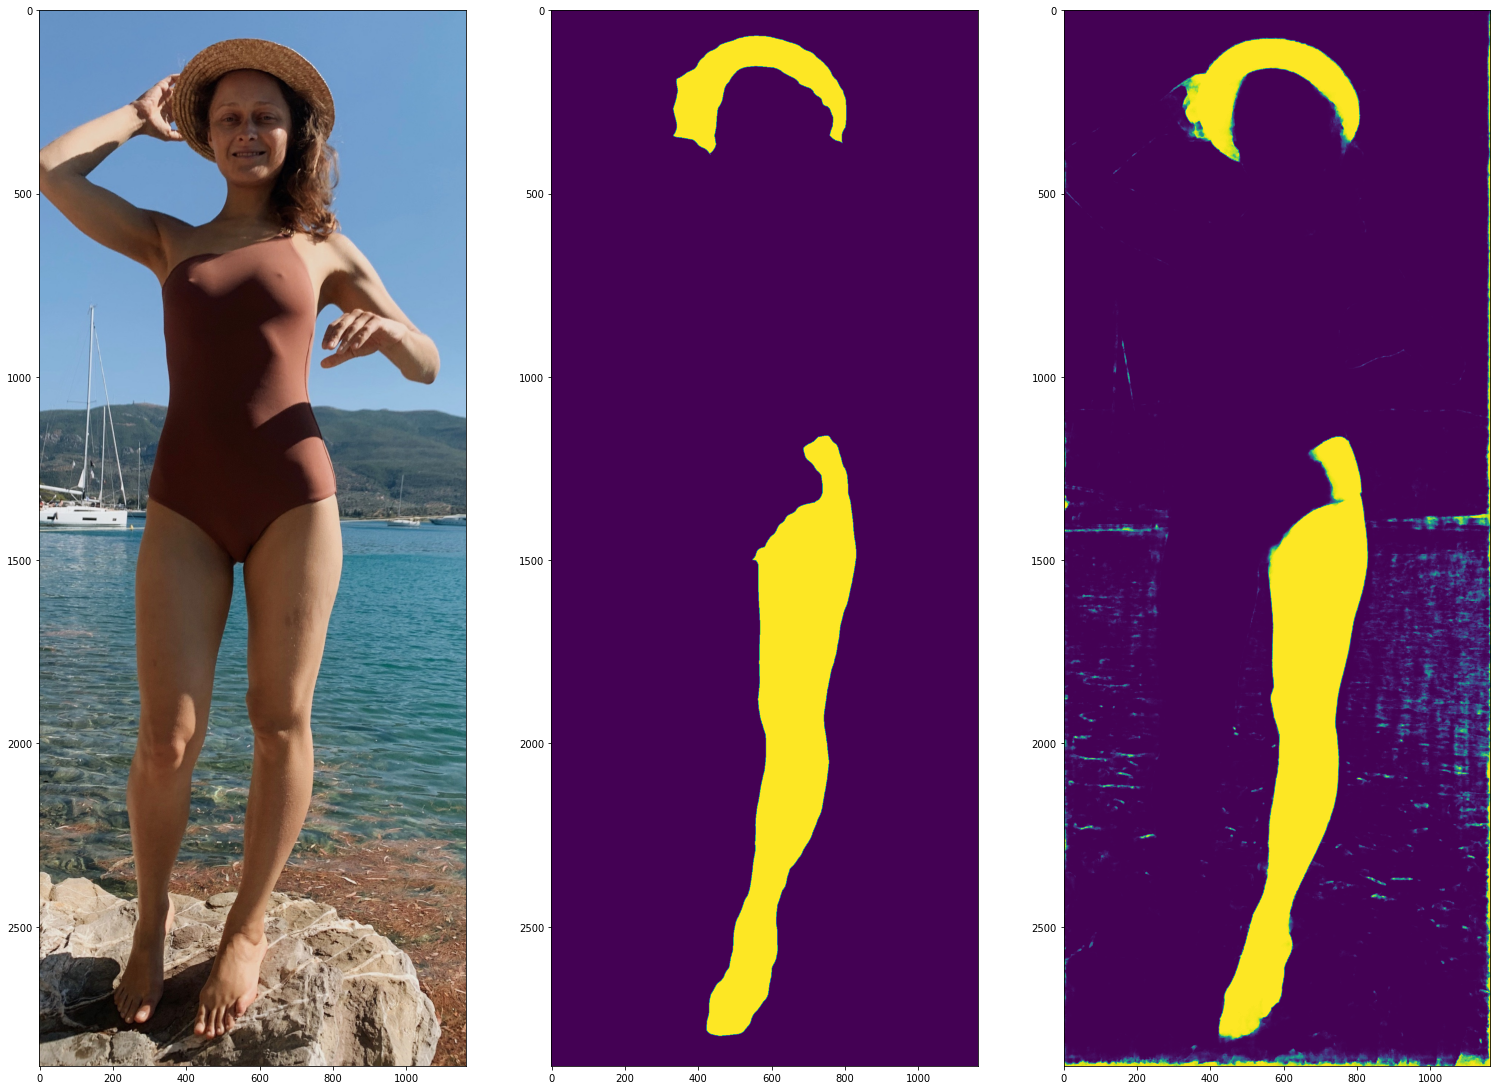

torch.Size([1, 1, 645, 602])
chunk_time: 429.7393798828125
batch_time: 439.5148010253906
(2880, 2304, 3)


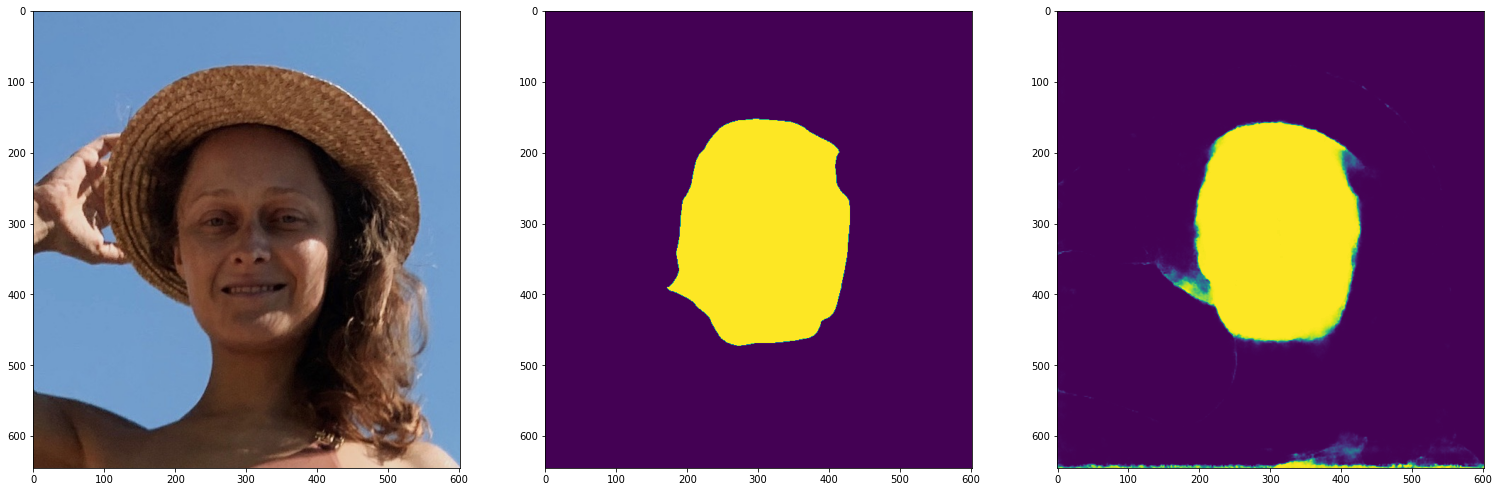

torch.Size([1, 1, 670, 429])
chunk_time: 304.3044128417969
batch_time: 311.02020263671875
(2880, 2304, 3)


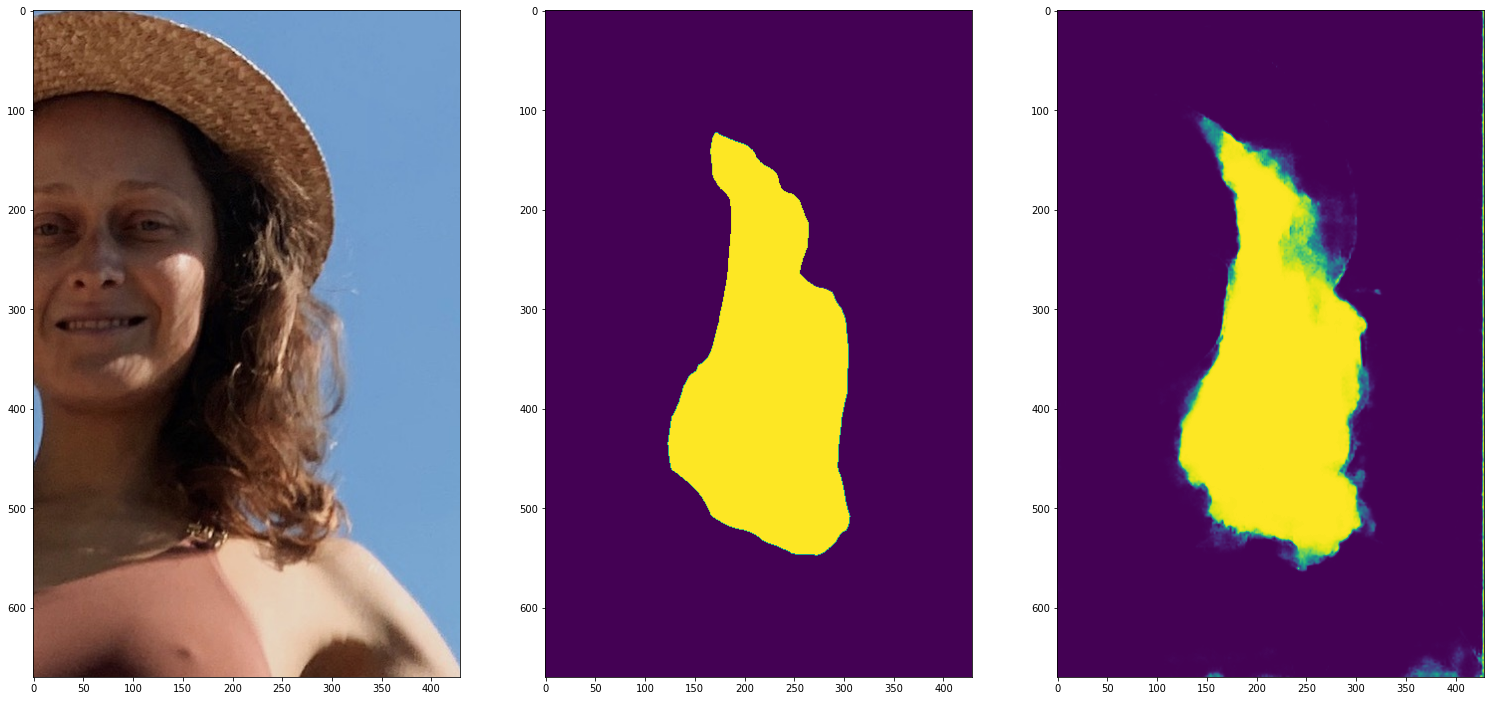

torch.Size([1, 1, 1775, 775])
chunk_time: 1107.8046875
chunk_time: 539.8516235351562
batch_time: 1671.9647216796875
(2880, 2304, 3)


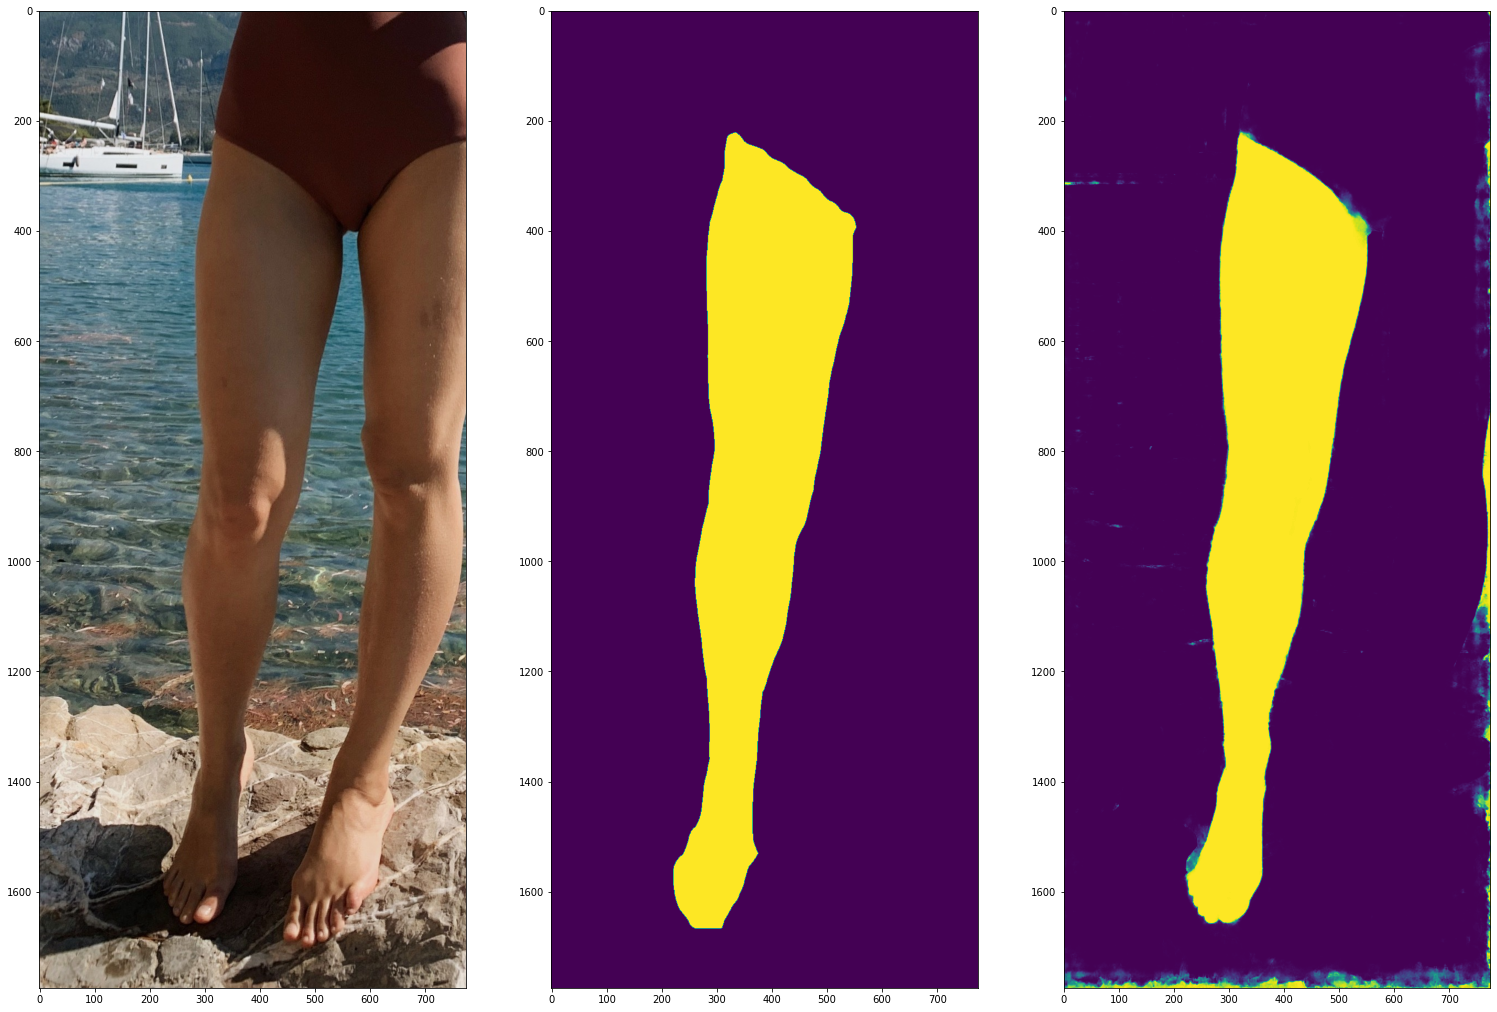

torch.Size([1, 1, 1396, 1092])
chunk_time: 1173.7921142578125
chunk_time: 668.2315673828125
batch_time: 1866.277099609375
(2880, 2304, 3)


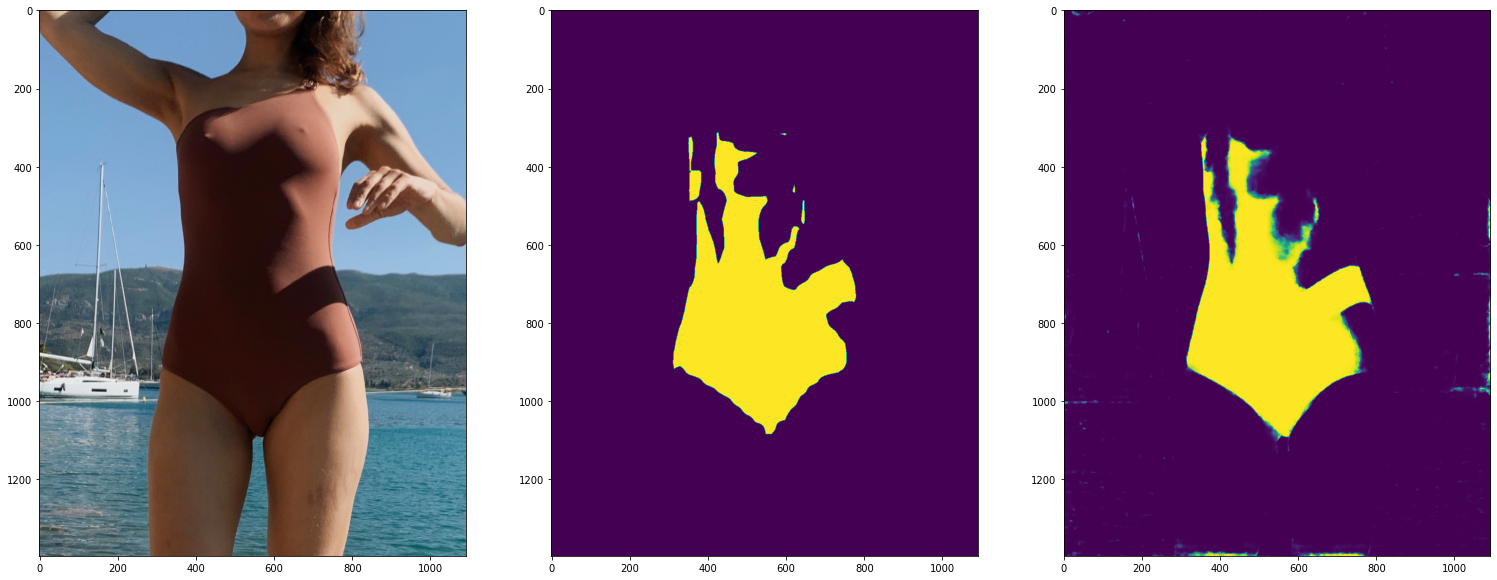

torch.Size([1, 1, 880, 812])
chunk_time: 843.2312622070312
batch_time: 857.8253784179688
(2880, 2304, 3)


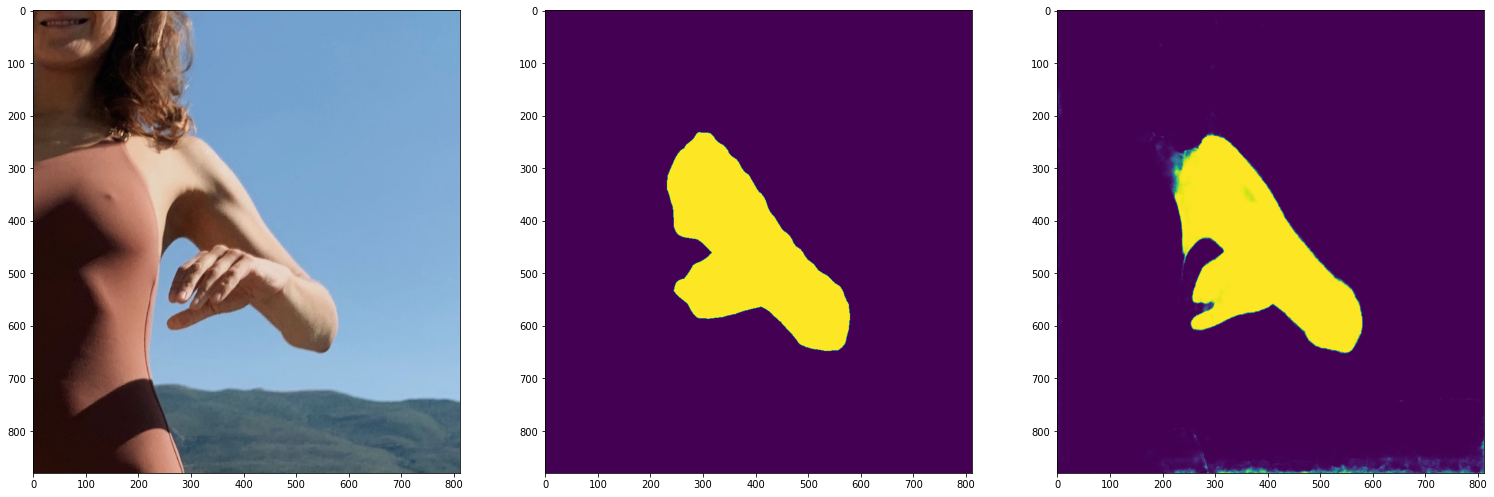

torch.Size([1, 1, 1036, 1031])
chunk_time: 1016.82861328125
chunk_time: 216.5353546142578
batch_time: 1253.7889404296875
(2880, 2304, 3)


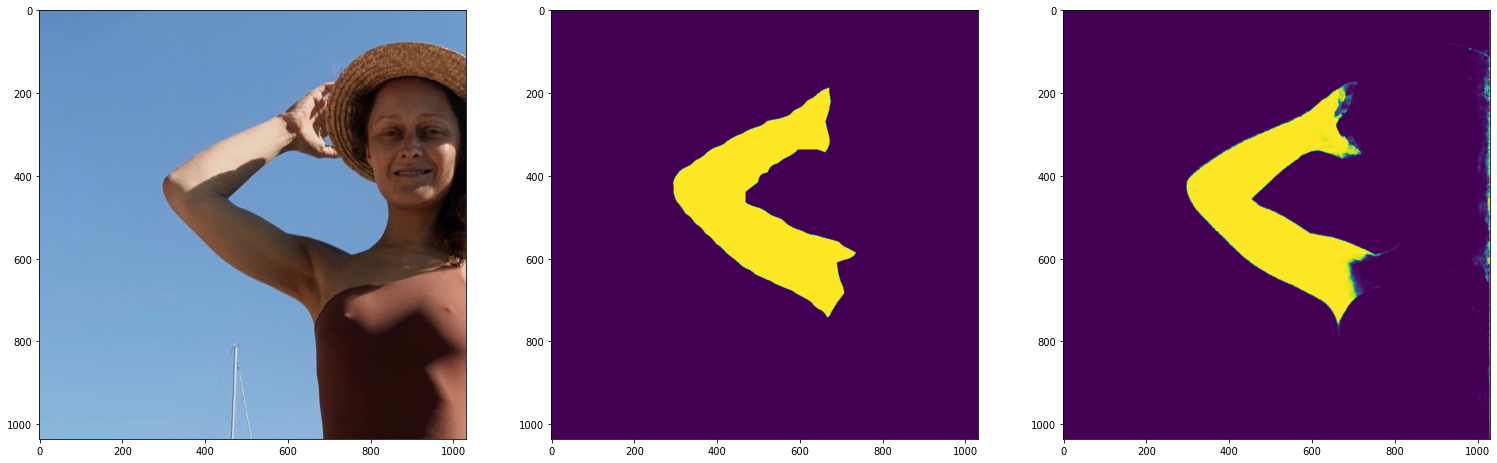

In [115]:
cropped_refs = {}
for cl in np.unique(mask):
    if cl == 0: continue
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(26, 20))
    cur_cls = mask.copy()
    
    cur_cls[cur_cls != cl] = 0
    
    bbox = extract_bboxes(cur_cls[None, :])[0]

    crp = cur_cls[bbox[1]:bbox[3],bbox[0]:bbox[2]]
    
    _, ref = sr(im[bbox[1]:bbox[3],bbox[0]:bbox[2]], crp)
    
    ax[0].imshow(im[bbox[1]:bbox[3],bbox[0]:bbox[2]])
    ax[1].imshow(crp)
    ax[2].imshow(ref[0].permute(1, 2, 0).detach().cpu().numpy())
    
    print(im.shape)
    restored_reff = torch.zeros(*mask.shape)
    restored_reff[bbox[1]:bbox[3],bbox[0]:bbox[2]] = ref
    cropped_refs[cl] = restored_reff
    plt.show()

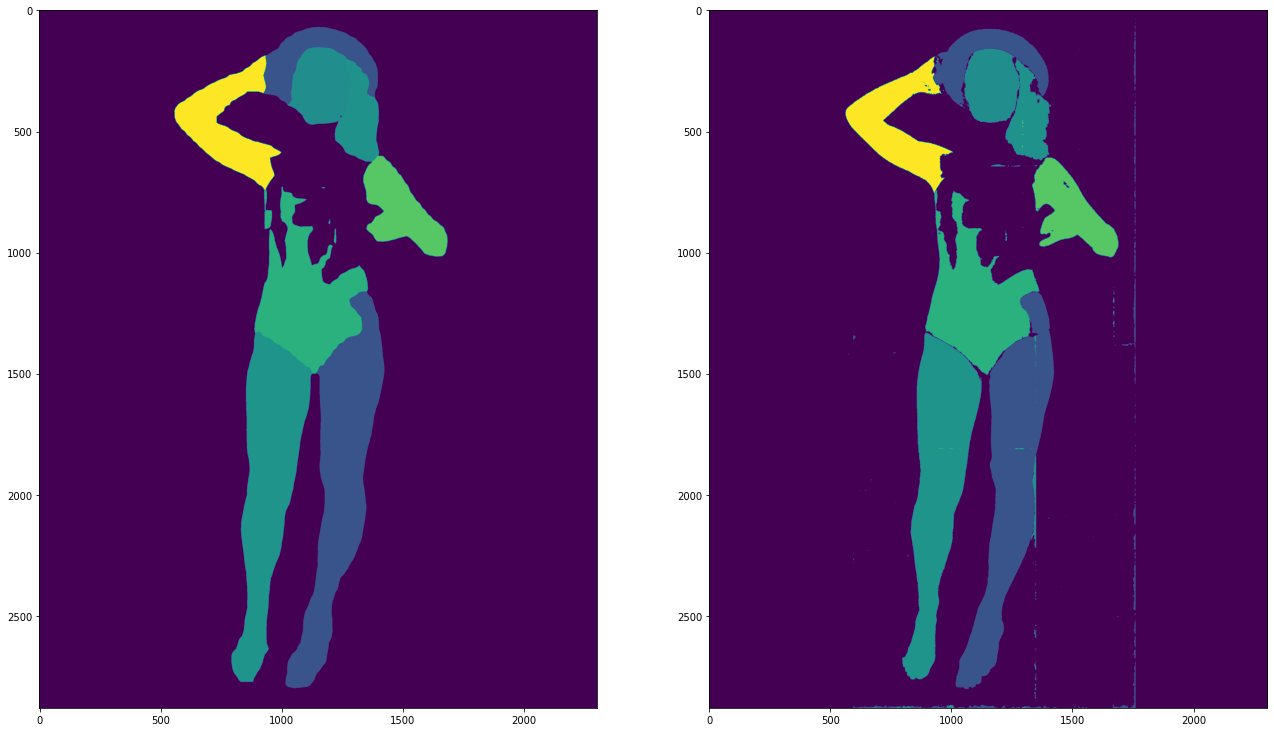

In [109]:
from_cropped_ref = torch.zeros(list(cropped_refs.items())[0][1].shape)
for cl, ref in cropped_refs.items():
    from_cropped_ref[ref > 0.95] = cl
    # from_cropped_ref = torch.max(torch.tensor(255), from_cropped_ref)
    
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22, 16))
ax[0].imshow(mask)
ax[1].imshow(from_cropped_ref)
plt.show()

## MultiClass Refinement example

In [1]:
import os
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import imageio

/home/hlovatskyi/anaconda3/envs/segm/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
hp_path, gt_path = "Self-Correction-Human-Parsing/outputs/9_im.png", "human/9_im.jpg"
im, mask = np.array(Image.open(gt_path).convert('RGB')), np.array(Image.open(hp_path).convert('L'))

In [3]:
from single_img_inf import MultiClassSegmRefiner
from single_img_inf import SingleClassRefiner

In [4]:
sr = SingleClassRefiner()
mcls_ref = MultiClassSegmRefiner(sr)

ASPP_4level


In [5]:
ref = mcls_ref(im, mask)

torch.Size([1, 1, 2880, 1164])
chunk_time: 3111.865478515625
chunk_time: 749.4201049804688
chunk_time: 753.6982421875
chunk_time: 745.0391235351562
chunk_time: 89.57273864746094
batch_time: 5510.59130859375


NameError: name 'mask' is not defined

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22, 18))
ax[0].imshow(im)
ax[1].imshow(mask)